In [1]:
import sys
print(sys.executable)

/home/vivivorropoulou/Transformer_Diffusion_Model_RUL_Battery_Prediction/.venv/bin/python


In [2]:
import numpy as np
import random
import math
import time
import os
os.environ['CUDA_LAUNCH_BLOCKING']="1"
os.environ['TORCH_USE_CUDA_DSA'] = "1"
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import pandas as pd
import pickle
import glob
#import xlrd
import scipy.io
import scipy.stats
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import transformers
import datetime
import yaml
import json
import argparse
from datetime import timedelta
from torch.utils.data import DataLoader, Dataset
from torch.optim import Adam
from tqdm import tqdm
%matplotlib inline
from math import sqrt
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from datetime import datetime

/home/vivivorropoulou/Transformer_Diffusion_Model_RUL_Battery_Prediction/.venv/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
import torch
if torch.cuda.is_available():
    print(f"CUDA is available. GPU is enabled: {torch.cuda.get_device_name(0)}")
else:
    print("CUDA is not available. GPU is not enabled.")

CUDA is available. GPU is enabled: NVIDIA GeForce GTX 1080 Ti


/home/vivivorropoulou/Transformer_Diffusion_Model_RUL_Battery_Prediction/.venv/lib/python3.8/site-packages/torch/cuda/__init__.py:152: UserWarning: 
    Found GPU3 Tesla K40c which is of cuda capability 3.5.
    PyTorch no longer supports this GPU because it is too old.
    The minimum cuda capability supported by this library is 3.7.
    
  warnings.warn(old_gpu_warn % (d, name, major, minor, min_arch // 10, min_arch % 10))


In [4]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [5]:
def drop_outlier(array,count,bins):
    index = []
    range_ = np.arange(1,count,bins)
    for i in range_[:-1]:
        array_lim = array[i:i+bins]
        sigma = np.std(array_lim)
        mean = np.mean(array_lim)
        th_max,th_min = mean + sigma*2, mean - sigma*2
        idx = np.where((array_lim < th_max) & (array_lim > th_min))
        idx = idx[0] + i
        index.extend(list(idx))
    return np.array(index)


In [6]:

from torch.utils.data import DataLoader, TensorDataset, random_split
import pandas as pd
from sklearn.preprocessing import MinMaxScaler


Battery_list = ['CS2_35', 'CS2_36', 'CS2_37', 'CS2_38']

dir_path = 'datasets/CALCE/'
Battery = {}
for name in Battery_list:
    print('Load Dataset ' + name + ' ...')
    path = glob.glob(dir_path + name + '/*.xlsx')
    dates = [pd.read_excel(p, sheet_name=1, engine='openpyxl')['Date_Time'][0] for p in path]
    idx = np.argsort(dates)
    path_sorted = np.array(path)[idx]
    
    count = 0
    discharge_capacities = []
    health_indicator = []
    internal_resistance = []
    CCCT = []
    CVCT = []
    time_list = []  # To store Date_Time values
    for p in path_sorted:
        df = pd.read_excel(p, sheet_name=1)
        print('Load ' + str(p) + ' ...')
        cycles = list(set(df['Cycle_Index']))
        for c in cycles:
            df_lim = df[df['Cycle_Index'] == c]
            #Charging
            df_c = df_lim[(df_lim['Step_Index'] == 2)|(df_lim['Step_Index'] == 4)]
            c_v = df_c['Voltage(V)']
            c_c = df_c['Current(A)']
            c_t = df_c['Test_Time(s)']
            #CC or CV
            df_cc = df_lim[df_lim['Step_Index'] == 2]
            df_cv = df_lim[df_lim['Step_Index'] == 4]
            CCCT.append(np.max(df_cc['Test_Time(s)'])-np.min(df_cc['Test_Time(s)']))
            CVCT.append(np.max(df_cv['Test_Time(s)'])-np.min(df_cv['Test_Time(s)']))

            #Discharging
            df_d = df_lim[df_lim['Step_Index'] == 7]
            d_v = df_d['Voltage(V)']
            d_c = df_d['Current(A)']
            d_t = df_d['Test_Time(s)']
            d_im = df_d['Internal_Resistance(Ohm)']
            d_time = pd.to_datetime(df_d['Date_Time']).astype(int) / 10**9  # Convert to timestamp
            
            if(len(list(d_c)) != 0):
                time_diff = np.diff(list(d_t))
                d_c = np.array(list(d_c))[1:]
                discharge_capacity = time_diff*d_c/3600 # Q = A*h
                discharge_capacity = [np.sum(discharge_capacity[:n]) for n in range(discharge_capacity.shape[0])]
                discharge_capacities.append(-1*discharge_capacity[-1])

                dec = np.abs(np.array(d_v) - 3.8)[1:]
                start = np.array(discharge_capacity)[np.argmin(dec)]
                dec = np.abs(np.array(d_v) - 3.4)[1:]
                end = np.array(discharge_capacity)[np.argmin(dec)]
                health_indicator.append(-1 * (end - start))

                internal_resistance.append(np.mean(np.array(d_im)))
                time_list.append(d_time.values[-1])  # Use the last timestamp for the cycle
                count += 1

    discharge_capacities = np.array(discharge_capacities)
    health_indicator = np.array(health_indicator)
    internal_resistance = np.array(internal_resistance)
    CCCT = np.array(CCCT)
    CVCT = np.array(CVCT)
    time_list = np.array(time_list)
    
    idx = drop_outlier(discharge_capacities, count, 40)
    df_result = pd.DataFrame({'cycle': np.linspace(1, idx.shape[0], idx.shape[0]),
                              'capacity': discharge_capacities[idx],
                              'SoH': health_indicator[idx],
                              'resistance': internal_resistance[idx],
                              'CCCT': CCCT[idx],
                              'CVCT': CVCT[idx],
                              'time': time_list[idx]})
    Battery[name] = df_result
    

Load Dataset CS2_35 ...
Load datasets/CALCE/CS2_35/CS2_35_8_17_10.xlsx ...
Load datasets/CALCE/CS2_35/CS2_35_8_18_10.xlsx ...
Load datasets/CALCE/CS2_35/CS2_35_8_19_10.xlsx ...
Load datasets/CALCE/CS2_35/CS2_35_8_30_10.xlsx ...
Load datasets/CALCE/CS2_35/CS2_35_9_7_10.xlsx ...
Load datasets/CALCE/CS2_35/CS2_35_9_8_10.xlsx ...
Load datasets/CALCE/CS2_35/CS2_35_9_21_10.xlsx ...
Load datasets/CALCE/CS2_35/CS2_35_9_30_10.xlsx ...
Load datasets/CALCE/CS2_35/CS2_35_10_15_10.xlsx ...
Load datasets/CALCE/CS2_35/CS2_35_10_22_10.xlsx ...
Load datasets/CALCE/CS2_35/CS2_35_10_29_10.xlsx ...
Load datasets/CALCE/CS2_35/CS2_35_11_01_10.xlsx ...
Load datasets/CALCE/CS2_35/CS2_35_11_08_10.xlsx ...
Load datasets/CALCE/CS2_35/CS2_35_11_23_10.xlsx ...
Load datasets/CALCE/CS2_35/CS2_35_11_24_10.xlsx ...
Load datasets/CALCE/CS2_35/CS2_35_12_06_10.xlsx ...
Load datasets/CALCE/CS2_35/CS2_35_12_13_10.xlsx ...
Load datasets/CALCE/CS2_35/CS2_35_12_20_10.xlsx ...
Load datasets/CALCE/CS2_35/CS2_35_12_23_10.xlsx ..

In [7]:
print(Battery['CS2_35'])

     cycle  capacity       SoH  resistance         CCCT         CVCT  \
0      1.0  1.126385  0.825175    0.094009  6613.059052  2251.498033   
1      2.0  1.126160  0.815965    0.091661  6612.402800  2231.967052   
2      3.0  1.125966  0.815977    0.094649  6608.560673  2228.216959   
3      4.0  1.118508  0.825194    0.091413  6604.732222  2247.561061   
4      5.0  1.117210  0.806900    0.091413  6629.211049  2077.692393   
..     ...       ...       ...         ...          ...          ...   
877  878.0  0.339218  0.128353    0.121454  1255.711238          NaN   
878  879.0  0.330025  0.128343    0.122852  1535.380556  3328.912803   
879  880.0  0.330027  0.119175    0.120863  1291.478395  3022.668035   
880  881.0  0.320860  0.119175    0.122264  1290.025300  3007.262188   
881  882.0  0.320863  0.119174    0.123185  1264.996494  3010.181684   

             time  
0    1.282068e+09  
1    1.282142e+09  
2    1.282241e+09  
3    1.282254e+09  
4    1.282266e+09  
..            .

In [8]:
for name in Battery_list: 
    total_cycles = df_result['cycle'].max()
    #df_result['RUL'] = total_cycles - df_result['cycle']

    # Normalize the features
    features = ['SoH', 'resistance', 'CCCT', 'CVCT', 'time']
    scaler = MinMaxScaler()
    df_result[features] = scaler.fit_transform(df_result[features])

    sequence_length = 50
    var = []
    target_var = []

    for i in range(len(df_result) - sequence_length):
        sequence = df_result[features].iloc[i:i + sequence_length].values
        time_seq = df_result['time'].iloc[i:i + sequence_length].values
        combined_seq = np.hstack((sequence, time_seq.reshape(-1, 1)))
        var.append(combined_seq)
        target_var.append(df_result['capacity'].iloc[i + sequence_length - 1])

    var = np.array(var)
    target_var = np.array(target_var)

    # Save preprocessed data to a pickle file
    pickle_file_path = f'preprocess/data/CALCE/{name}_processed.pkl'
    with open(pickle_file_path, 'wb') as f:
        pickle.dump({'var': var, 'target_var': target_var}, f)

In [9]:
def read_pickle_file(pickle_file_path):
    with open(pickle_file_path, 'rb') as f:
        data = pickle.load(f)
    print(f"Loaded data from {pickle_file_path}")
    print(f"Keys: {list(data.keys())}")
    print(f"var shape: {data['var'].shape}")
    print(f"target_var shape: {data['target_var'].shape}")

    print("var:")
    print(data['var'])
    print("target_var:")
    print(data['target_var'])
    return data

# Example
#pickle_file_path = 'preprocess/data/CALCE/CS2_35_processed.pkl'
#data = read_pickle_file(pickle_file_path)

Loaded data from preprocess/data/CALCE/CS2_35_processed.pkl
Keys: ['var', 'target_var']
var shape: (946, 50, 6)
target_var shape: (946,)
var:
[[[0.95363034 0.15011982 0.99586801 0.65931065 0.         0.        ]
  [0.95360544 0.1660067  0.99385012 0.66007905 0.00501781 0.00501781]
  [0.95359206 0.17246755 0.99303952 0.66027125 0.01172583 0.01172583]
  ...
  [0.90705697 0.28070628 0.938392   0.61077594 0.04990867 0.04990867]
  [0.90705856 0.30079351 0.9184615  0.65523624 0.05074571 0.05074571]
  [0.90703566 0.35746456 0.91218343 0.67034914 0.05158323 0.05158323]]

 [[0.95360544 0.1660067  0.99385012 0.66007905 0.00501781 0.00501781]
  [0.95359206 0.17246755 0.99303952 0.66027125 0.01172583 0.01172583]
  [0.95357807 0.1660067  0.9920447  0.66541511 0.01261495 0.01261495]
  ...
  [0.90705856 0.30079351 0.9184615  0.65523624 0.05074571 0.05074571]
  [0.90703566 0.35746456 0.91218343 0.67034914 0.05158323 0.05158323]
  [0.90704112 0.39464216 0.90452302 0.68958842 0.05242197 0.05242197]]

 [

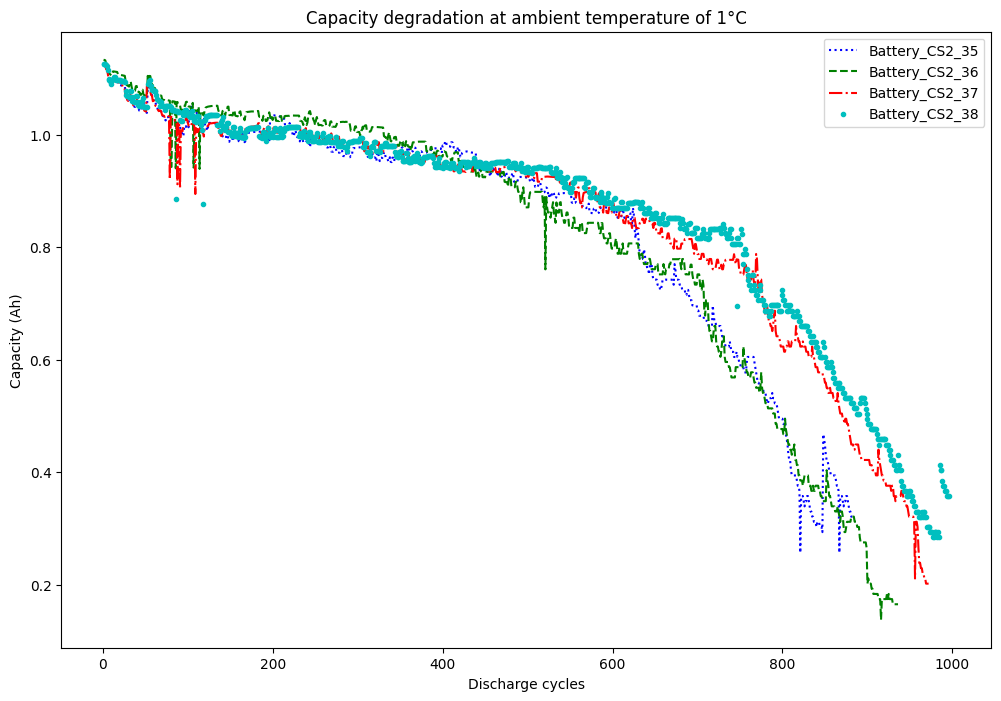

In [10]:
# Rated_Capacity = 1.1
fig, ax = plt.subplots(1, figsize=(12, 8))
color_list = ['b:', 'g--', 'r-.', 'c.']
for name,color in zip(Battery_list, color_list):
    df_result = Battery[name]
    ax.plot(df_result['cycle'], df_result['capacity'], color, label='Battery_'+name)
ax.set(xlabel='Discharge cycles', ylabel='Capacity (Ah)', title='Capacity degradation at ambient temperature of 1°C')
plt.legend()

In [11]:
def get_dataloader(pickle_file_path, batch_size=32):
    with open(pickle_file_path, 'rb') as f:
        data = pickle.load(f)
    
    var = data['var']
    target_var = data['target_var']

    X_tensor = torch.tensor(var, dtype=torch.float32)
    y_tensor = torch.tensor(target_var, dtype=torch.float32).view(-1, 1)
    dataset = TensorDataset(X_tensor, y_tensor)


    train_size = int(0.7 * len(dataset))
    valid_size = int(0.15 * len(dataset))
    test_size = len(dataset) - (train_size + valid_size)
    train_dataset, valid_dataset, test_dataset = random_split(dataset, [train_size, valid_size, test_size])


    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, valid_loader, test_loader

In [12]:
class TimeEmbedding(nn.Module):
    def __init__(self, time_points, time_embedding_dim, device):
        super().__init__()
        self.time_embedding = nn.Embedding(time_points, time_embedding_dim).to(device)

    def forward(self, x):
        return self.time_embedding(x)

class Conv1d_with_init(nn.Conv1d):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, padding=0, dilation=1, groups=1, bias=True, padding_mode='zeros'):
        super().__init__(in_channels, out_channels, kernel_size, stride, padding, dilation, groups, bias, padding_mode)
        nn.init.kaiming_normal_(self.weight)
        if self.bias is not None:
            nn.init.constant_(self.bias, 0)

class DiffusionEmbedding(nn.Module):
    def __init__(self, num_steps, embedding_dim, device):
        super().__init__()
        self.device = device
        self.register_buffer('diffusion_embedding', self._build_embedding(num_steps, embedding_dim // 2), persistent=False)
        self.projection1 = nn.Linear(embedding_dim, embedding_dim).to(device)
        self.projection2 = nn.Linear(embedding_dim, embedding_dim).to(device)

    def forward(self, diffusion_step):
        x = self.diffusion_embedding[diffusion_step]
        if x.dim() == 1:
            x = x.unsqueeze(0)
        x = self.projection1(x)
        x = F.silu(x)
        x = self.projection2(x)
        x = F.silu(x)
        return x

    def _build_embedding(self, num_steps, dim):
        steps = torch.arange(num_steps).unsqueeze(1).to(self.device)
        frequencies = (10.0 ** (torch.arange(dim) / (dim - 1) * 4.0).unsqueeze(0)).to(self.device)
        table = steps * frequencies
        table = torch.cat([torch.sin(table), torch.cos(table)], dim=1)
        return table

class ResNet(nn.Module):
    def __init__(self, config, device, data_path):
        super().__init__()
        self.device = device
        with open(data_path, 'rb') as f:
            data = pickle.load(f)
        var = data['var']
        target_var = data['target_var']
        lv = len(var)
        self.size_x = config['size']
        self.channels = config['channels']
        num_features = var.shape[-1] # Total number of features
        #print(f"Number of features: {num_features}") # Debugging statement
        self.emb_f = nn.Embedding(lv + 1, self.channels).to(self.device)
        self.emb_t = TimeEmbedding(config['time_points'],config['time_embedding_dim'], self.device)
        self.emb_v = nn.Linear(num_features - 2, self.channels).to(self.device) # Adjust input dimension to match additional features in samples_x
        self.dec1 = Conv1d_with_init(self.channels, self.channels, 1, self.device)
        self.dec2 = Conv1d_with_init(self.channels, 1, 1, self.device)
        self.diffusion_embedding = DiffusionEmbedding(config['num_steps'],config['diffusion_embedding_dim'], self.device)
        self.diffusion_projection = nn.Linear(config['diffusion_embedding_dim'], self.channels).to(self.device)
        self.residual_layers = nn.ModuleList([
            TransformerLayer(config, self.device)
            for _ in range(config['layers'])
        ])
        self.to(self.device)

    def forward(self, samples_x, samples_y, diffusion_step):
        diffusion_emb = self.diffusion_embedding(diffusion_step)
        diffusion_emb = self.diffusion_projection(diffusion_emb)
        diffusion_emb = diffusion_emb.unsqueeze(1).expand(diffusion_emb.shape[0], self.size_x, diffusion_emb.shape[1])

        # Ensure indices are within range
        samples_x[:, :, 0] = samples_x[:, :, 0].clamp(0, self.emb_f.num_embeddings - 1).long()
        samples_x[:, :, 1] = samples_x[:, :, 1].clamp(0, self.emb_t.time_embedding.size(0) - 1).long()
        samples_y_repeated = samples_y.unsqueeze(1)  # From [batch_size, 50, 1] to [batch_size, 1, 50, 1]
        samples_y_repeated = samples_y_repeated.expand(-1, samples_x.size(1), -1, -1).contiguous()  # To [batch_size, 50, 50, 1
        samples_y_repeated = samples_y_repeated.view(samples_y_repeated.size(0), samples_y_repeated.size(1), -1)  # To [batch_size, 50, 50]
        samples_y_repeated = samples_y_repeated[:, :, :samples_x.size(2)]  # To [batch_size, 50, 6]

        # Embeddings
        x_emb_f = self.emb_f(samples_x[:, :, 0].long())
        x_emb_t = self.emb_t(samples_x[:, :, 1].long())
        x_emb_v = self.emb_v(samples_x[:, :, 2:].float())
        y_emb_f = self.emb_f(samples_y_repeated[:, :, 0].long())
        y_emb_t = self.emb_t(samples_y_repeated[:, :, 1].long())
        y_emb_v = self.emb_v(samples_y_repeated[:, :, 2:].float().to(self.device))

        x_emb = x_emb_f + x_emb_t + x_emb_v
        y_emb = y_emb_f + y_emb_t + y_emb_v

        skip = []
        for layer in self.residual_layers:
            y_emb = y_emb + diffusion_emb
            y_emb, skip_connection = layer(x_emb, y_emb)
            skip.append(skip_connection)
        output = torch.sum(torch.stack(skip), dim=0) / math.sqrt(len(self.residual_layers))
        output = self.dec1(output.permute(0, 2, 1))
        output = F.relu(output)
        output = self.dec2(output)

        return output.squeeze()

class TransformerLayer(nn.Module):
    def __init__(self, config, device):
        super().__init__()
        self.layer_norm = nn.LayerNorm(config['channels'])
        self.attn = nn.MultiheadAttention(embed_dim=config['channels'], num_heads=config['num_heads'])
        self.ffn = nn.Sequential(
            nn.Linear(config['channels'], config['channels'] * 4),
            nn.ReLU(),
            nn.Linear(config['channels'] * 4, config['channels']),
        )
        self.dropout = nn.Dropout(config.get('dropout', 0.1))
        self.device = device

    def forward(self, x, y):
        y = self.layer_norm(y)
        attn_output, _ = self.attn(y, y, y)
        y = y + self.dropout(attn_output)
        y = y + self.dropout(self.ffn(y))
        return y, y

In [13]:
class TDSTF(nn.Module):
    def __init__(self, config, device, data_path):
        super().__init__()
        self.device = device
        with open(data_path, 'rb') as f:
            data = pickle.load(f)
        var = data['var']
        target_var = data['target_var']
        lv = len(var)
        self.size_x = config['diffusion']['size']
        self.channels = config['diffusion']['channels']
        num_features = var.shape[-1] 
        self.emb_f = nn.Embedding(lv + 1, self.channels).to(self.device)
        self.emb_t = TimeEmbedding(config['diffusion']['time_points'], config['diffusion']['time_embedding_dim'], self.device)
        self.emb_v = nn.Linear(num_features - 2, self.channels).to(self.device) 
        self.dec1 = Conv1d_with_init(self.channels, self.channels, 1)
        self.dec2 = Conv1d_with_init(self.channels, 1, 1)
        self.diffusion_embedding = DiffusionEmbedding(config['diffusion']['num_steps'], config['diffusion']['diffusion_embedding_dim'], self.device)
        self.diffusion_projection = nn.Linear(config['diffusion']['diffusion_embedding_dim'], self.channels).to(self.device)
        self.residual_layers = nn.ModuleList([
            TransformerLayer(config['diffusion'], self.device)
            for _ in range(config['diffusion']['layers'])
        ])
        self.to(self.device)

    def forward(self, samples_x, samples_y, diffusion_step):
        max_step = self.diffusion_embedding.diffusion_embedding.size(0) - 1
        diffusion_step = min(max(diffusion_step, 0), max_step)

        diffusion_emb = self.diffusion_embedding(diffusion_step)
        diffusion_emb = self.diffusion_projection(diffusion_emb)

        if diffusion_emb.dim() == 1:
            diffusion_emb = diffusion_emb.unsqueeze(0)
        if diffusion_emb.dim() == 2:
            diffusion_emb = diffusion_emb.unsqueeze(0)
        diffusion_emb = diffusion_emb.expand(diffusion_emb.shape[0], self.size_x, diffusion_emb.shape[2])

        samples_x[:, :, 0] = samples_x[:, :, 0].clamp(0, self.emb_f.num_embeddings - 1).long()
        samples_x[:, :, 1] = samples_x[:, :, 1].clamp(0, self.emb_t.time_embedding.num_embeddings - 1).long()

        samples_y_repeated = samples_y.unsqueeze(1).expand(samples_y.size(0), samples_x.size(1), samples_y.size(1)).contiguous()
        samples_y_repeated = samples_y_repeated.expand(samples_y_repeated.size(0), samples_y_repeated.size(1), samples_x.size(2))

        x_emb_f = self.emb_f(samples_x[:, :, 0].long())
        x_emb_t = self.emb_t(samples_x[:, :, 1].long())
        x_emb_v = self.emb_v(samples_x[:, :, 2:].float())
        y_emb_f = self.emb_f(samples_y_repeated[:, :, 0].long())
        y_emb_t = self.emb_t(samples_y_repeated[:, :, 1].long())
        y_emb_v = self.emb_v(samples_y_repeated[:, :, 2:].float().to(self.device))

        x_emb = x_emb_f + x_emb_t + x_emb_v
        y_emb = y_emb_f + y_emb_t + y_emb_v

        skip = []
        for layer in self.residual_layers:
            # Align dimensions if necessary
            if y_emb.shape[1] != diffusion_emb.shape[1]:
                if y_emb.shape[1] > diffusion_emb.shape[1]:
                    y_emb = y_emb[:, :diffusion_emb.shape[1], :]
                else:
                    diffusion_emb = diffusion_emb[:, :y_emb.shape[1], :]

            y_emb = y_emb + diffusion_emb
            y_emb, skip_connection = layer(x_emb, y_emb)
            skip.append(skip_connection)

        output = torch.sum(torch.stack(skip), dim=0) / math.sqrt(len(self.residual_layers))

        output = self.dec1(output.permute(0, 2, 1))
        output = F.relu(output)
        output = self.dec2(output)

        return output.squeeze()

    def process(self, batch):
        samples_x, samples_y = batch
        samples_x = samples_x.float().to(self.device)
        samples_y = samples_y.float().reshape(-1, 1).to(self.device)
        return samples_x, samples_y

    def forecast(self, samples_x, samples_y, n_samples):
        generation = torch.zeros(n_samples, samples_y.shape[0], samples_y.shape[-1]).to(self.device)
        for i in range(n_samples):
            samples_y = torch.randn_like(samples_y)
            for t in range(self.config_diff['num_steps'] - 1, -1, -1):
                predicted = self.res_model(samples_x, samples_y, torch.tensor([t]).to(self.device))
                coeff1 = 1 / self.alpha_hat[t] ** 0.5
                coeff2 = (1 - self.alpha_hat[t]) / (1 - self.alpha[t]) ** 0.5
                samples_y = coeff1 * (samples_y - coeff2 * predicted)
                if t > 0:
                    noise = torch.randn_like(samples_y)
                    sigma = ((1.0 - self.alpha[t - 1]) / (1.0 - self.alpha[t]) * self.beta[t]) ** 0.5
                    samples_y += sigma * noise

            generation[i] = samples_y.detach()
        return generation.permute(1, 2, 0)

    def evaluate(self, batch, n_samples):
        samples_x, samples_y = self.process(batch)
        with torch.no_grad():
            generation = self.forecast(samples_x, samples_y, n_samples)
        return generation, samples_y, samples_x

In [14]:
def train(model, config, train_loader, valid_loader=None, foldername='', data_path=''):
    optimizer = torch.optim.Adam(model.parameters(), lr=config['train']['lr'], weight_decay=5e-8)
    if foldername != '':
        output_path = os.path.join(foldername, 'model.pth')

    num_epochs = config['train']['epochs']
    size_y = config['diffusion']['size']

    lr_scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[i * 10 for i in range(1, num_epochs // 10)], gamma=0.8)

    ct = 0
    best_valid_loss = np.inf

    for epoch in range(num_epochs):
        avg_loss = 0
        model.train()
        with tqdm(train_loader, mininterval=5.0, maxinterval=50.0) as it:
            for batch_no, (samples_x, samples_y) in enumerate(it, start=1):
                samples_x, samples_y = samples_x.to(model.device), samples_y.to(model.device)
                optimizer.zero_grad()
                outputs = model(samples_x, samples_y, config['diffusion']['size'])
                samples_y_resized = samples_y.view(outputs.size(0), -1)
                loss = F.mse_loss(outputs, samples_y_resized)
                loss.backward()
                optimizer.step()
                avg_loss += loss.item()
                it.set_postfix(avg_epoch_loss=avg_loss / batch_no, epoch=epoch, lr=optimizer.param_groups[0]['lr'])

            lr_scheduler.step()
        if valid_loader and (epoch + 1) % 10 == 0 and epoch > 135:
            model.eval()
            CRPS_valid, _ = evaluate(0, model, valid_loader, nsample=5, foldername=foldername)
            print(f'{best_valid_loss:.4f} (best)')
            print(f'{CRPS_valid:.4f} (current)')
            if best_valid_loss > CRPS_valid:
                ct = 0
                best_valid_loss = CRPS_valid
                torch.save(model.state_dict(), output_path)
                print('model updated')
            else:
                ct += 1
                print(f'count: {ct}')
            if ct > 2:
                model.load_state_dict(torch.load(output_path))
                print('stop')
                break

def calc_metrics(is_test, all_generation, all_samples_y):
    MSE = None
    target = all_samples_y.squeeze() 
    if is_test == 1:
        quantiles = np.arange(0.05, 1.0, 0.05)
        gt = target
        mask = torch.ones_like(gt)
        prediction = all_generation.median(dim=1).values
        MSE = ((prediction - gt) * mask) ** 2
        MSE = MSE.sum() / mask.sum()
    else:
        quantiles = np.arange(0.25, 1.0, 0.25)
    denom = torch.sum(torch.abs(target))
    CRPS = 0
    for i in range(len(quantiles)):
        q_pred = []
        for j in range(len(all_generation)):
            q_value = torch.quantile(all_generation[j], quantiles[i], dim=0)
            if q_value.dim() == 0:
                q_value = q_value.unsqueeze(0)
            q_pred.append(q_value)
        q_pred = torch.cat(q_pred, 0).reshape(-1)
        target = target.reshape(-1)
        q_loss = 2 * torch.sum(torch.abs((q_pred - target) * ((target <= q_pred) * 1.0 - quantiles[i])))
        CRPS += q_loss / denom
    return CRPS.item() / len(quantiles), MSE

def evaluate(is_test, model, data_loader, nsample=100, foldername=""):
    with torch.no_grad():
        model.eval()
        all_samples_x = []
        all_samples_y = []
        all_generation = []
        with tqdm(data_loader, mininterval=5.0, maxinterval=50.0) as it:
            for batch_no, batch in enumerate(it, start=1):
                samples_x, samples_y = batch
                samples_x, samples_y = samples_x.to(model.device), samples_y.to(model.device)
                generation = model(samples_x, samples_y, diffusion_step=0)
                all_generation.append(generation)
                all_samples_x.append(samples_x)
                all_samples_y.append(samples_y)

            all_generation = torch.cat(all_generation)
            all_samples_x = torch.cat(all_samples_x)
            all_samples_y = torch.cat(all_samples_y)
            CRPS, MSE = calc_metrics(is_test, all_generation, all_samples_y)
            if is_test == 1:
                pickle.dump([all_generation, all_samples_y, all_samples_x], open(os.path.join(foldername, f"generated_outputs{nsample}.pkl"), "wb"))
                pickle.dump([CRPS, MSE], open(os.path.join(foldername, f"result_nsample{nsample}.pkl"), "wb"))
            return CRPS, MSE

In [16]:
CUDA_LAUNCH_BLOCKING = 1
import argparse
import torch
import datetime
import json
import yaml
import os
parser = argparse.ArgumentParser(description='')
parser.add_argument('--device', default='cpu')
parser.add_argument('--modelfolder', type=str, default='')
parser.add_argument('--nsample', type=int, default=10)
args, unknown = parser.parse_known_args()
print(args)
config = yaml.safe_load(open('config/base.yaml', 'r'))
print(json.dumps(config, indent=4))
default_batch_size = 32
batch_size = config.get('train', {}).get('batch_size', default_batch_size)
current_time = datetime.datetime.now().strftime('%Y%m%d_%H%M%S')
base_foldername = './save/CALCE/attention_' + current_time + '/'
print('model base folder:', base_foldername)
os.makedirs(base_foldername, exist_ok=True)

# Training for each battery
for battery in Battery_list:
    print(f"Training for battery: {battery}")
    data_path = f'preprocess/data/{battery}_processed.pkl'
    foldername = base_foldername + battery + '/'
    os.makedirs(foldername, exist_ok=True)

    # Load the data
    train_loader, valid_loader, test_loader = get_dataloader(data_path, batch_size)
    model = TDSTF(config, args.device, data_path).to(args.device)

    if args.modelfolder == '':
        train(
            model,
            config,
            train_loader,
            valid_loader=valid_loader,
            foldername=foldername,
            data_path=data_path
        )
    else:
        model.load_state_dict(torch.load('./save/CALCE/' + args.modelfolder + '/model.pth'))

    print('test')
    NACRPS, MSE = evaluate(1, model, test_loader, nsample=args.nsample, foldername=foldername)
    print('NACRPS: {}'.format(NACRPS))
    print('MSE: {}'.format(MSE))

Namespace(device='cpu', modelfolder='', nsample=10)
{
    "train": {
        "epochs": 200,
        "batch_size": 32,
        "lr": 0.001
    },
    "diffusion": {
        "size": 50,
        "layers": 3,
        "channels": 128,
        "num_heads": 8,
        "ff_dim": 512,
        "time_points": 40,
        "diffusion_embedding_dim": 128,
        "time_embedding_dim": 128,
        "beta_start": 0.0001,
        "beta_end": 0.5,
        "num_steps": 50
    }
}
model base folder: ./save/CALCE/attention_20240625_164505/
Training for battery: CS2_35


  0%|          | 0/21 [00:00<?, ?it/s]/tmp/ipykernel_1372419/2403787807.py:24: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32, 50])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.mse_loss(outputs, samples_y_resized)
  0%|          | 0/21 [00:00<?, ?it/s, avg_epoch_loss=41.7, epoch=0, lr=0.001]

  0%|          | 0/21 [00:00<?, ?it/s, avg_epoch_loss=9.16, epoch=0, lr=0.001]/tmp/ipykernel_1372419/2403787807.py:24: UserWarning: Using a target size (torch.Size([22, 1])) that is different to the input size (torch.Size([22, 50])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.mse_loss(outputs, samples_y_resized)
100%|██████████| 5/5 [00:00<00:00, 86.77it/s]


inf (best)
0.0945 (current)
model updated


100%|██████████| 5/5 [00:00<00:00, 83.81it/s]


0.0945 (best)
0.0883 (current)
model updated


100%|██████████| 5/5 [00:00<00:00, 86.07it/s]


0.0883 (best)
0.0921 (current)
count: 1


100%|██████████| 5/5 [00:00<00:00, 85.25it/s]


0.0883 (best)
0.0776 (current)
model updated


100%|██████████| 5/5 [00:00<00:00, 89.93it/s]


0.0776 (best)
0.0852 (current)
count: 1


100%|██████████| 5/5 [00:00<00:00, 74.50it/s]


0.0776 (best)
0.0980 (current)
count: 2


100%|██████████| 5/5 [00:00<00:00, 85.68it/s]


0.0776 (best)
0.0912 (current)
count: 3
stop
test


100%|██████████| 5/5 [00:00<00:00, 79.47it/s]


NACRPS: 0.07329912562119334
MSE: 0.0040821474976837635
Training for battery: CS2_36


100%|██████████| 5/5 [00:00<00:00, 85.01it/s]


inf (best)
0.0362 (current)
model updated


100%|██████████| 5/5 [00:00<00:00, 87.64it/s]


0.0362 (best)
0.0382 (current)
count: 1


100%|██████████| 5/5 [00:00<00:00, 81.24it/s]


0.0362 (best)
0.0384 (current)
count: 2


100%|██████████| 5/5 [00:00<00:00, 84.82it/s]


0.0362 (best)
0.0367 (current)
count: 3
stop
test


100%|██████████| 5/5 [00:00<00:00, 83.94it/s]


NACRPS: 0.03731939039732281
MSE: 0.0011774733429774642
Training for battery: CS2_37


100%|██████████| 5/5 [00:00<00:00, 82.03it/s]


inf (best)
0.1023 (current)
model updated


100%|██████████| 5/5 [00:00<00:00, 81.22it/s]


0.1023 (best)
0.1028 (current)
count: 1


100%|██████████| 5/5 [00:00<00:00, 86.89it/s]


0.1023 (best)
0.1007 (current)
model updated


100%|██████████| 5/5 [00:00<00:00, 85.00it/s]


0.1007 (best)
0.1008 (current)
count: 1


100%|██████████| 5/5 [00:00<00:00, 85.71it/s]


0.1007 (best)
0.1035 (current)
count: 2


100%|██████████| 5/5 [00:00<00:00, 86.92it/s]


0.1007 (best)
0.1050 (current)
count: 3
stop
test


100%|██████████| 5/5 [00:00<00:00, 80.30it/s]


NACRPS: 0.10712830643904836
MSE: 0.008333222940564156
Training for battery: CS2_38


100%|██████████| 5/5 [00:00<00:00, 82.93it/s]


inf (best)
0.0684 (current)
model updated


100%|██████████| 5/5 [00:00<00:00, 87.61it/s]


0.0684 (best)
0.0701 (current)
count: 1


100%|██████████| 5/5 [00:00<00:00, 79.27it/s]


0.0684 (best)
0.0709 (current)
count: 2


100%|██████████| 5/5 [00:00<00:00, 85.17it/s]


0.0684 (best)
0.0687 (current)
count: 3
stop
test


100%|██████████| 5/5 [00:00<00:00, 82.28it/s]


NACRPS: 0.07079835314499705
MSE: 0.003828020766377449
